In [1]:
import pandas as pd
import numpy as np
#from signal_filtering import butter_highpass_filter
#from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import seaborn as sns
from scipy import stats
from torch.autograd import Variable

%matplotlib inline

from torch import nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv("train.csv")
df.drop(df.columns[[0, 1,6,7,8]], axis = 1, inplace = True) 
df.head(10)

,activity_ID,16g_acc_x,16g_acc_y,16g_acc_z,gyroscope_x,gyroscope_y,gyroscope_z
0,0,-2.523174,0.638704,0.353806,-0.018261,-0.002568,0.004911
1,0,3.859764,-0.984588,-0.529219,0.034743,0.003378,-0.015060
2,0,1.460387,-0.349027,-0.285561,0.001189,-0.003244,0.017939
3,0,-1.320136,0.347531,0.291641,-0.011087,-0.000596,-0.007024
4,0,-2.254299,0.534639,0.344219,-0.017177,0.024410,-0.001884
5,0,-1.115861,0.239828,0.126407,-0.013250,-0.019524,-0.006404
6,0,0.229772,-0.051808,-0.122391,0.010658,-0.015654,0.006204
7,0,1.016572,-0.148509,-0.163267,0.019075,0.013322,0.001412
8,0,1.044065,-0.324543,-0.114416,0.030157,-0.008835,-0.003679
9,0,0.579547,-0.054715,0.035769,-0.013229,-0.000226,0.023129


In [3]:

df['acc_z_diff'] = df['16g_acc_z']-df['16g_acc_z'].shift(-1)
df['gyr_z_diff'] = df['gyroscope_z']-df['gyroscope_z'].shift(-1)
print(df.shape)
df.head()

(391243, 9)


,activity_ID,16g_acc_x,16g_acc_y,16g_acc_z,gyroscope_x,gyroscope_y,gyroscope_z,acc_z_diff,gyr_z_diff
0,0,-2.523174,0.638704,0.353806,-0.018261,-0.002568,0.004911,0.883026,0.019972
1,0,3.859764,-0.984588,-0.529219,0.034743,0.003378,-0.015060,-0.243658,-0.033000
2,0,1.460387,-0.349027,-0.285561,0.001189,-0.003244,0.017939,-0.577201,0.024963
3,0,-1.320136,0.347531,0.291641,-0.011087,-0.000596,-0.007024,-0.052578,-0.005140
4,0,-2.254299,0.534639,0.344219,-0.017177,0.024410,-0.001884,0.217812,0.004520


In [4]:
def remove_10_seconds(dataset):
    dataset['act_block'] = (dataset['activity_ID'].shift(1) != dataset['activity_ID']).astype(int).cumsum()
    drop_index = []
    numblocks = dataset['act_block'].max()
    for block in range(1, numblocks + 1):
        drop_index += list(dataset[dataset['act_block'] == block].head(1000).index)
        drop_index += list(dataset[dataset['act_block'] == block].tail(1000).index)
    dataset = dataset.drop(drop_index)
    dataset = dataset.dropna()
    dataset = dataset.drop(['act_block'], axis=1)
    return dataset

In [5]:
df = remove_10_seconds(df)

In [6]:
Fs = 50
frame_size = Fs*2 # 200
hop_size = Fs # 100

In [7]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 8

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        a_x = df['16g_acc_x'].values[i: i + frame_size]
        a_y = df['16g_acc_y'].values[i: i + frame_size]
        a_z = df['16g_acc_z'].values[i: i + frame_size]
        g_x = df['gyroscope_x'].values[i: i + frame_size]
        g_y = df['gyroscope_y'].values[i: i + frame_size]
        g_z = df['gyroscope_z'].values[i: i + frame_size]
        d_a_z = df['acc_z_diff'].values[i: i + frame_size]
        d_g_z = df['gyr_z_diff'].values[i: i + frame_size]
        
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['activity_ID'][i: i + frame_size])[0][0]
        frames.append([a_x, a_y, a_z,g_x,g_y,g_z,d_a_z,d_g_z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, N_FEATURES ,frame_size)
    labels = np.asarray(labels)

    return frames, labels



In [8]:
#segments
segments, labels = get_frames(df, frame_size, hop_size)

segments.shape, labels.shape

((6703, 8, 100), (6703,))

In [9]:
print(np.array(segments).shape)
print(np.array(labels).shape)

(6703, 8, 100)
(6703,)


In [10]:
reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, 8, 100)
#labels = np.asarray(pd.get_dummies(labels), dtype = np.float32)

In [11]:
print(labels[:5])

[0 0 0 0 0]


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
        reshaped_segments, labels, test_size=0.2, random_state=42)
#print(y_test)

In [13]:
import torch
# A `numpy array` can easily be made into a `torch.Tensor´
torch_train_x = torch.tensor(X_train, dtype=torch.float32)
wind_train_y = torch.tensor(y_train, dtype=torch.int64)
torch_val_x = torch.tensor(X_val, dtype=torch.float32)
wind_val_y = torch.tensor(y_val, dtype=torch.int64)
tr_dataset = TensorDataset(torch_train_x, wind_train_y)
te_dataset = TensorDataset(torch_val_x, wind_val_y)

print('Training set input size: ' + str(torch_train_x.size()))
print('Training set labels size: ' + str(wind_train_y.size()))

print('val set input size: ' + str(torch_val_x.size()))
print('val set labels size: ' + str(wind_val_y.size()))

Training set input size: torch.Size([5362, 8, 100])
Training set labels size: torch.Size([5362])
val set input size: torch.Size([1341, 8, 100])
val set labels size: torch.Size([1341])


In [14]:
wind_train_x = torch_train_x.view(torch_train_x.size(0), 1, 8, 100)
wind_val_x = torch_val_x.view(torch_val_x.size(0), 1, 8, 100)

print('Training set input size: ' + str(wind_train_x.size()))
print('Training set labels size: ' + str(wind_train_y.size()))

print('val set input size: ' + str(wind_val_x.size()))
print('val set labels size: ' + str(wind_val_y.size()))

Training set input size: torch.Size([5362, 1, 8, 100])
Training set labels size: torch.Size([5362])
val set input size: torch.Size([1341, 1, 8, 100])
val set labels size: torch.Size([1341])


In [15]:
from torch.utils.data import TensorDataset, DataLoader

# Specify seed for reproducibility
torch.manual_seed(42)

batch = 264

train_dataset = DataLoader(dataset=TensorDataset(wind_train_x, wind_train_y), batch_size=batch, shuffle=True)
val_dataset = DataLoader(dataset=TensorDataset(wind_val_x, wind_val_y), batch_size=wind_val_x.size(0), shuffle=True)
#print(train_dataset.size(0))

In [16]:
import torch.nn as nn
from torch.nn import functional as F

class ConvUIL(nn.Module):
    
    input_size = [8,100]
    output_size = 5
    input_channels = 1
    channels_conv1 = 16
    channels_conv2 = 48
    kernel_conv1 = [1, 13]
    kernel_conv2 = [1, 13]
    pool_conv1 = [1, 2]
    pool_conv2 = [1, 2]
    channels_conv3 = 96
    channels_conv4 = 128
    channels_conv5 = 264
    kernel_conv3 = [1, 11]
    kernel_conv4 = [1, 3]
    kernel_conv5 = [1, 3]
    
    
    fcl1_size = 256
    
    def __init__(self):
        super(ConvUIL, self).__init__()
        
        # Define the convolutional layers
        self.conv1 = nn.Conv2d(self.input_channels, self.channels_conv1, self.kernel_conv1)
        #self.bn1=nn.BatchNorm2d(self.channels_conv1)
        self.conv2 = nn.Conv2d(self.channels_conv1, self.channels_conv2, self.kernel_conv2)
        #self.bn2=nn.BatchNorm2d(self.channels_conv2)
        self.conv3 = nn.Conv2d(self.channels_conv2, self.channels_conv3, self.kernel_conv3)
        #self.bn3=nn.BatchNorm2d(self.channels_conv3)       
        self.conv4 = nn.Conv2d(self.channels_conv3, self.channels_conv4, self.kernel_conv4)
        #self.bn4=nn.BatchNorm2d(self.channels_conv4)       
        self.conv5 = nn.Conv2d(self.channels_conv4, self.channels_conv5, self.kernel_conv5)
        
        # Calculate the convolutional layers output size (stride = 1)
        
        self.conv_out_size = int(4224)
        
        
        # Define the fully connected layers
        self.fcl1 = nn.Linear(self.conv_out_size, self.fcl1_size)
        self.fcl2 = nn.Linear(self.fcl1_size, self.output_size)
        
        #self.fcl3 = nn.Linear(128, self.output_size)
        
    def forward(self, x):
        # Apply convolution 1 and pooling
        x = self.conv1(x)
        #x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, self.pool_conv1)
        
        # Apply convolution 2 and pooling
        x = self.conv2(x)
        #x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, self.pool_conv2)
        
        # Apply convolution 3 
        x = self.conv3(x)
        #x = self.bn3(x)
        x = F.relu(x)
        
        # Apply convolution 4
        x = self.conv4(x)
        #x = self.bn4(x)
        x = F.relu(x)
        
        # Apply convolution 5 
        x = self.conv5(x)
        x = F.relu(x)
        
        # Reshape x to one dimmension to use as input for the fully connected layers
        x = x.view(-1, self.conv_out_size)
        
        # Fully connected layers
        x = self.fcl1(x)
        x = F.relu(x)
        x = self.fcl2(x)
        #x = F.relu(x)
        
        
        #x = self.fcl3(x)
        
        
        return F.log_softmax(x, dim = 1)

In [17]:
convUIL = ConvUIL()
print(convUIL)

ConvUIL(
  (conv1): Conv2d(1, 16, kernel_size=[1, 13], stride=(1, 1))
  (conv2): Conv2d(16, 48, kernel_size=[1, 13], stride=(1, 1))
  (conv3): Conv2d(48, 96, kernel_size=[1, 11], stride=(1, 1))
  (conv4): Conv2d(96, 128, kernel_size=[1, 3], stride=(1, 1))
  (conv5): Conv2d(128, 264, kernel_size=[1, 3], stride=(1, 1))
  (fcl1): Linear(in_features=4224, out_features=256, bias=True)
  (fcl2): Linear(in_features=256, out_features=5, bias=True)
)


In [18]:
for param in convUIL.parameters():
    print(param.size())

torch.Size([16, 1, 1, 13])
torch.Size([16])
torch.Size([48, 16, 1, 13])
torch.Size([48])
torch.Size([96, 48, 1, 11])
torch.Size([96])
torch.Size([128, 96, 1, 3])
torch.Size([128])
torch.Size([264, 128, 1, 3])
torch.Size([264])
torch.Size([256, 4224])
torch.Size([256])
torch.Size([5, 256])
torch.Size([5])


In [19]:
from torch import optim
criterion = nn.NLLLoss()
optimizer = optim.Adam(convUIL.parameters(), lr=0.001)

In [20]:
from torch.autograd import Variable
#Model training and saving best model
epochs = 30
best_accuracy=0.0
train_count = wind_train_y.size(0)
val_count = wind_val_y.size(0)

best_accuracy=0.0
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(epochs):
    
    #Evaluation and training of dataset
    convUIL.train()
    train_accuracy=0.0
    train_loss=0.0
    val_loss=0.0
    
    for observations,labels in train_dataset:
        observations = Variable(observations)
        labels = Variable(labels)
            
        optimizer.zero_grad()
        
        outputs=convUIL(observations)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        train_loss+= loss.data*observations.size(0)
        _,prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
        
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
 # Evaluation on validation dataset
    convUIL.eval()
    
    val_accuracy=0.0
    for observations,labels in val_dataset:
        observations = Variable(observations)
        labels = Variable(labels)
            
        outputs=convUIL(observations)
        v_loss=criterion(outputs,labels)
        #v_loss.backward()
        #optimizer.step()
        val_loss+= v_loss.data*observations.size(0)
        _,prediction=torch.max(outputs.data,1)
        val_accuracy+=int(torch.sum(prediction==labels.data))
        
        
        val_accuracy = val_accuracy/val_count
        val_loss=val_loss/val_count
        train_loss_list.append(train_loss)
        train_acc_list.append(train_accuracy)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_accuracy)
        if val_accuracy > best_accuracy:
            torch.save(convUIL.state_dict(),'best_checkpoint.model')
            best_accuracy=val_accuracy
    
        print('Epoch: '+str(epoch)+' Train Loss: '+str(train_loss)+' Train Accuracy: '+str(train_accuracy)+' val Loss: '+str(val_loss)+' Validation Accuracy: '+str(val_accuracy))
    

Epoch: 0 Train Loss: tensor(1.2472) Train Accuracy: 0.5048489369638195 val Loss: tensor(0.9995) Validation Accuracy: 0.680089485458613
Epoch: 1 Train Loss: tensor(0.8856) Train Accuracy: 0.6887355464378964 val Loss: tensor(0.7459) Validation Accuracy: 0.7121551081282624
Epoch: 2 Train Loss: tensor(0.7217) Train Accuracy: 0.726408056695263 val Loss: tensor(0.6975) Validation Accuracy: 0.7337807606263982
Epoch: 3 Train Loss: tensor(0.6454) Train Accuracy: 0.741514360313316 val Loss: tensor(0.6445) Validation Accuracy: 0.7419835943325876
Epoch: 4 Train Loss: tensor(0.6099) Train Accuracy: 0.7508392390898918 val Loss: tensor(0.6347) Validation Accuracy: 0.7583892617449665
Epoch: 5 Train Loss: tensor(0.5814) Train Accuracy: 0.7702349869451697 val Loss: tensor(0.5774) Validation Accuracy: 0.7718120805369127
Epoch: 6 Train Loss: tensor(0.5705) Train Accuracy: 0.7702349869451697 val Loss: tensor(0.5669) Validation Accuracy: 0.7740492170022372
Epoch: 7 Train Loss: tensor(0.5471) Train Accuracy:

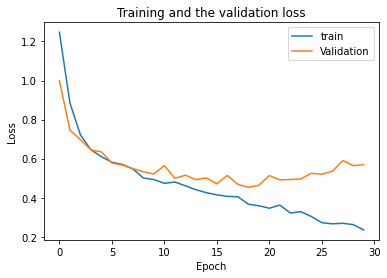

In [21]:
# YOUR CODE HERE
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list,label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and the validation loss')
plt.legend()
plt.show()

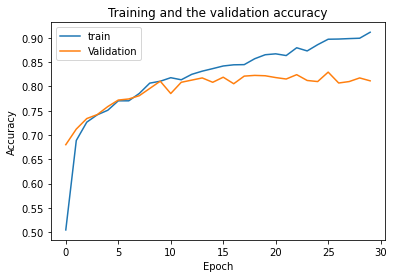

In [22]:
# YOUR CODE HERE
plt.plot(train_acc_list, label='train')
plt.plot(val_acc_list,label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and the validation accuracy')
plt.legend()
plt.show()

In [23]:
test_df = pd.read_csv("testsubject8.csv")
test_df.drop(test_df.columns[[0, 1,6,7,8]], axis = 1, inplace = True) 
test_df.head(10)

,activity_ID,16g_acc_x,16g_acc_y,16g_acc_z,gyroscope_x,gyroscope_y,gyroscope_z
0,0,-0.145869,-2.239288,1.247878,-0.001670,0.000314,0.000951
1,0,0.223255,3.416402,-1.883032,0.015635,-0.005920,-0.003254
2,0,0.066204,1.312503,-0.700944,-0.025306,0.012719,0.001809
3,0,-0.094050,-1.236104,0.528362,-0.001580,0.007566,0.003159
4,0,0.012696,-1.822008,1.074035,0.012129,-0.024133,-0.002446
5,0,-0.155430,-1.145991,0.715581,0.010832,-0.018924,-0.002375
6,0,-0.057844,0.218567,-0.086060,-0.003126,0.020177,-0.000545
7,0,0.111424,0.909484,-0.507324,0.002921,0.036269,0.016653
8,0,-0.008949,0.942309,-0.592906,-0.017081,-0.009115,-0.019073
9,0,0.082863,0.494852,-0.337328,-0.004265,-0.013408,-0.007959


In [24]:
test_df['acc_z_diff'] = test_df['16g_acc_z']-test_df['16g_acc_z'].shift(-1)
test_df['gyr_z_diff'] = test_df['gyroscope_z']-test_df['gyroscope_z'].shift(-1)
print(test_df.shape)
test_df.head()

(93860, 9)


,activity_ID,16g_acc_x,16g_acc_y,16g_acc_z,gyroscope_x,gyroscope_y,gyroscope_z,acc_z_diff,gyr_z_diff
0,0,-0.145869,-2.239288,1.247878,-0.001670,0.000314,0.000951,3.130909,0.004205
1,0,0.223255,3.416402,-1.883032,0.015635,-0.005920,-0.003254,-1.182088,-0.005063
2,0,0.066204,1.312503,-0.700944,-0.025306,0.012719,0.001809,-1.229305,-0.001350
3,0,-0.094050,-1.236104,0.528362,-0.001580,0.007566,0.003159,-0.545673,0.005605
4,0,0.012696,-1.822008,1.074035,0.012129,-0.024133,-0.002446,0.358453,-0.000070


In [25]:
test_df = remove_10_seconds(test_df)

In [26]:
Fs = 50
frame_size = Fs*2 # 200
hop_size = Fs # 100

In [27]:
X_test, Y_test = get_frames(test_df, frame_size, hop_size)

X_test.shape, Y_test.shape

((1596, 8, 100), (1596,))

In [28]:
X_test = np.asarray(X_test, dtype= np.float32).reshape(-1, 8, 100)
X_test.shape

(1596, 8, 100)

In [29]:
torch_test_x = torch.tensor(X_test, dtype=torch.float32)
torch_test_y = torch.tensor(Y_test, dtype=torch.int64)
test_dataset = TensorDataset(torch_test_x, torch_test_y)

print('Test set input size: ' + str(torch_test_x.size()))
print('Test set labels size: ' + str(torch_test_y.size()))


Test set input size: torch.Size([1596, 8, 100])
Test set labels size: torch.Size([1596])


In [30]:
test_train_x = torch_test_x.view(torch_test_x.size(0), 1, 8, 100)

print('Test set input size: ' + str(test_train_x.size()))


Test set input size: torch.Size([1596, 1, 8, 100])


In [31]:
batch = 264

test_dataset = DataLoader(dataset=TensorDataset(test_train_x, torch_test_y), batch_size=batch, shuffle=True)


# Last model

In [32]:
# Test the model on the test data
loss = 0
correct = 0
total = torch_test_y.size(0)
predictions=[]
print(total)
for observations, labels in test_dataset:
    observations = Variable(observations)
    labels = Variable(labels)
        
    # Forward pass
    outputs = convUIL(observations)
    _, predicted = torch.max(outputs.data, 1)
    predictions.append(predicted.numpy())
    correct += int((predicted == labels).sum())
              
accuracy = correct / total
print('Test Accuracy with model: %.4f' % (accuracy))
                     


1596
Test Accuracy with model: 0.6779


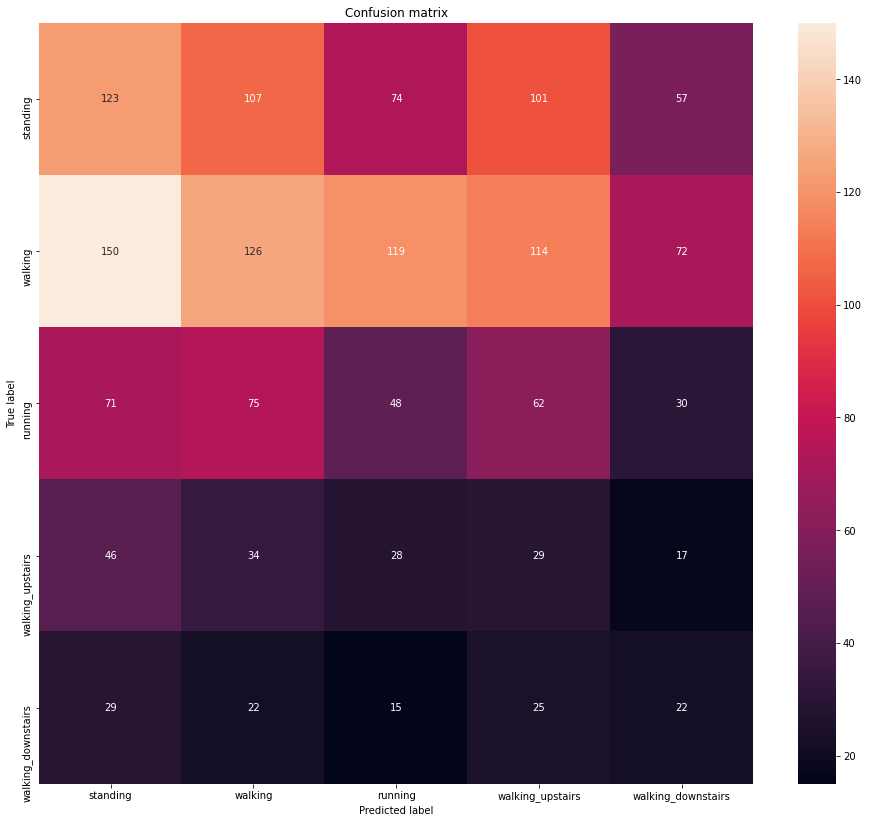

In [33]:
predicted_output=[]
predicted_output = [item for sublist in predictions for item in sublist]
import sklearn.metrics as metrics
LABELS = ['standing', 'walking', 'running', 'walking_upstairs', 'walking_downstairs']
actual_output = Y_test
confusion_matrix = metrics.confusion_matrix(actual_output, predicted_output)
plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();


# Best model

In [34]:
#Loading best model
best_model = ConvUIL()
best_model.load_state_dict(torch.load('best_checkpoint.model'))
best_model.eval()

ConvUIL(
  (conv1): Conv2d(1, 16, kernel_size=[1, 13], stride=(1, 1))
  (conv2): Conv2d(16, 48, kernel_size=[1, 13], stride=(1, 1))
  (conv3): Conv2d(48, 96, kernel_size=[1, 11], stride=(1, 1))
  (conv4): Conv2d(96, 128, kernel_size=[1, 3], stride=(1, 1))
  (conv5): Conv2d(128, 264, kernel_size=[1, 3], stride=(1, 1))
  (fcl1): Linear(in_features=4224, out_features=256, bias=True)
  (fcl2): Linear(in_features=256, out_features=5, bias=True)
)

In [35]:
# Test the model on the test subject(Subject 8)for best model
loss = 0
correct = 0
total = torch_test_y.size(0)
predictions=[]

for observations, labels in test_dataset:
    observations = Variable(observations)
    labels = Variable(labels)
        
    # Forward pass
    outputs = best_model(observations)
    _, predicted = torch.max(outputs.data, 1)
    predictions.append(predicted.numpy())
    correct += int((predicted == labels).sum())
              
accuracy = correct / total
print('Test Accuracy with best model: %.4f' % (accuracy))

Test Accuracy with best model: 0.6353


In [36]:
predicted_output=[]
predicted_output = [item for sublist in predictions for item in sublist]

In [37]:
import sklearn.metrics as metrics

In [38]:
LABELS = ['standing', 'walking', 'running', 'walking_upstairs', 'walking_downstairs']
actual_output = Y_test
confusion_matrix = metrics.confusion_matrix(actual_output, predicted_output)

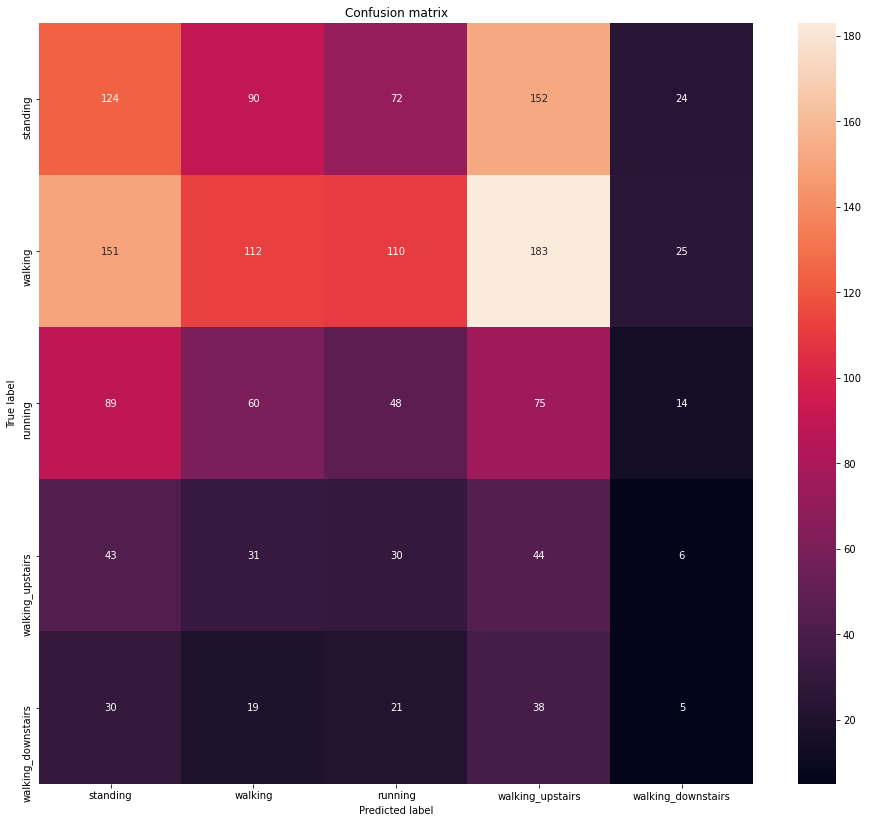

In [39]:
plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

# Model 77

In [40]:
#Loading best model
best_model = ConvUIL()
best_model.load_state_dict(torch.load('best_checkpoint_77.model'))
best_model.eval()

ConvUIL(
  (conv1): Conv2d(1, 16, kernel_size=[1, 13], stride=(1, 1))
  (conv2): Conv2d(16, 48, kernel_size=[1, 13], stride=(1, 1))
  (conv3): Conv2d(48, 96, kernel_size=[1, 11], stride=(1, 1))
  (conv4): Conv2d(96, 128, kernel_size=[1, 3], stride=(1, 1))
  (conv5): Conv2d(128, 264, kernel_size=[1, 3], stride=(1, 1))
  (fcl1): Linear(in_features=4224, out_features=256, bias=True)
  (fcl2): Linear(in_features=256, out_features=5, bias=True)
)

In [41]:
# Test the best_checkpoint_77 on the test subject(Subject 8)
loss = 0
correct = 0
total = torch_test_y.size(0)
predictions=[]

for observations, labels in test_dataset:
    observations = Variable(observations)
    labels = Variable(labels)
        
    # Forward pass
    outputs = best_model(observations)
    _, predicted = torch.max(outputs.data, 1)
    predictions.append(predicted.numpy())
    correct += int((predicted == labels).sum())
              
accuracy = correct / total
print('Test Accuracy with best model: %.4f' % (accuracy))

Test Accuracy with best model: 0.7751


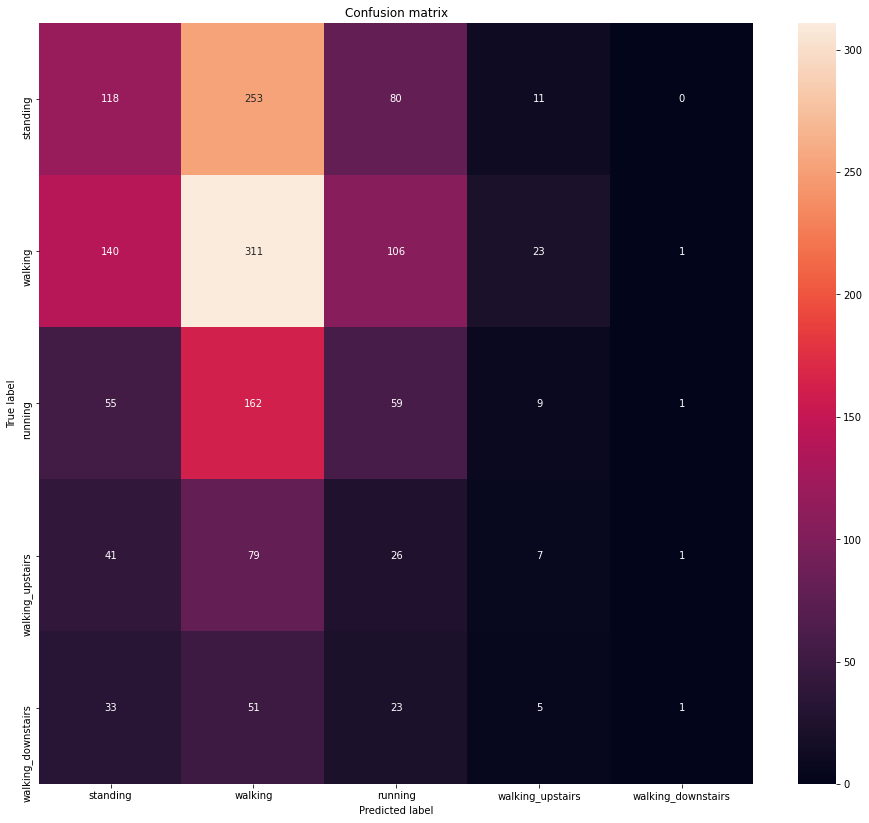

In [42]:
predicted_output = []
predicted_output = [item for sublist in predictions for item in sublist]
#import sklearn.metrics as metrics
LABELS = ['standing', 'walking', 'running', 'walking_upstairs', 'walking_downstairs']
actual_output = Y_test
confusion_matrix = metrics.confusion_matrix(actual_output, predicted_output)
plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();

# Model 75

In [43]:
#Loading best model
best_model = ConvUIL()
best_model.load_state_dict(torch.load('best_checkpoint_75.model'))
best_model.eval()

ConvUIL(
  (conv1): Conv2d(1, 16, kernel_size=[1, 13], stride=(1, 1))
  (conv2): Conv2d(16, 48, kernel_size=[1, 13], stride=(1, 1))
  (conv3): Conv2d(48, 96, kernel_size=[1, 11], stride=(1, 1))
  (conv4): Conv2d(96, 128, kernel_size=[1, 3], stride=(1, 1))
  (conv5): Conv2d(128, 264, kernel_size=[1, 3], stride=(1, 1))
  (fcl1): Linear(in_features=4224, out_features=256, bias=True)
  (fcl2): Linear(in_features=256, out_features=5, bias=True)
)

In [44]:
# Test the best_checkpoint_75 on the test subject(Subject 8)
loss = 0
correct = 0
total = torch_test_y.size(0)
predictions=[]

for observations, labels in test_dataset:
    observations = Variable(observations)
    labels = Variable(labels)
        
    # Forward pass
    outputs = best_model(observations)
    _, predicted = torch.max(outputs.data, 1)
    predictions.append(predicted.numpy())
    correct += int((predicted == labels).sum())
              
accuracy = correct / total
print('Test Accuracy with best model: %.4f' % (accuracy))

Test Accuracy with best model: 0.8277


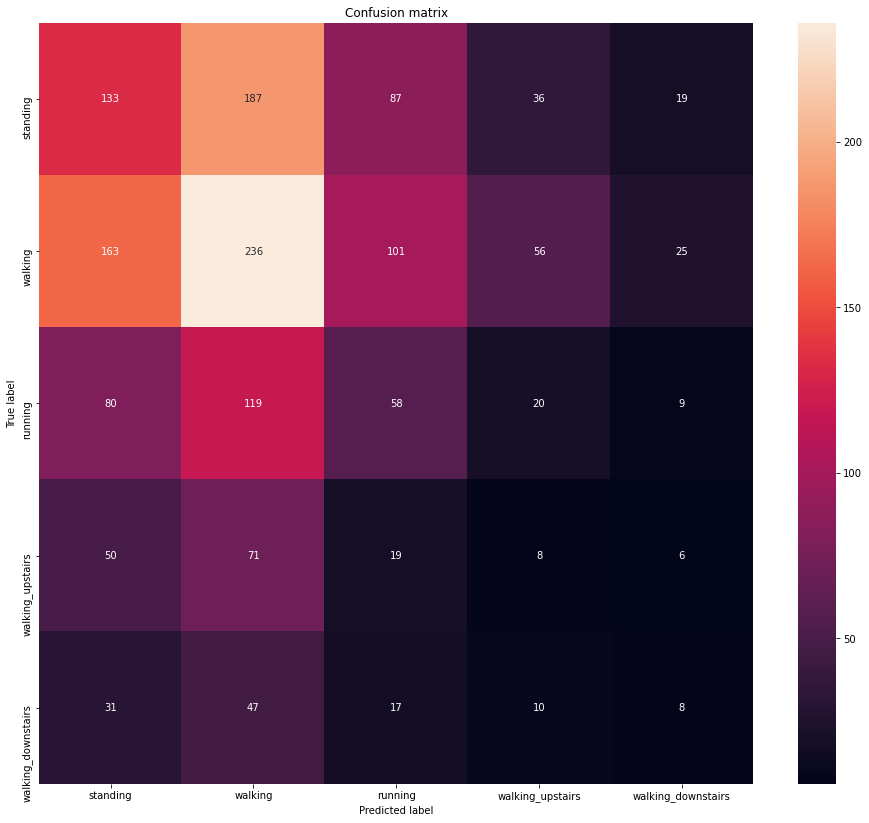

In [45]:
predicted_output = []
predicted_output = [item for sublist in predictions for item in sublist]
#import sklearn.metrics as metrics
LABELS = ['standing', 'walking', 'running', 'walking_upstairs', 'walking_downstairs']
actual_output = Y_test
confusion_matrix = metrics.confusion_matrix(actual_output, predicted_output)
plt.figure(figsize=(16, 14))
sns.heatmap(confusion_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show();